In [1]:
from __future__ import print_function, division

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from sklearn.metrics import euclidean_distances

In [4]:
from scipy.sparse import csr_matrix

In [5]:
np.random.seed(1)

## From spectral clustering tutorial (2006 paper by von Luxburg)

In [6]:
use_nearest_neighbors = True
use_normalized = False
use_sorted = True

cluster_sizes = 100*np.array([1, 1, 4, 4])
sigma_similarity = 1.0
num_neighbors = 200
sigma_cluster = 0.5  # Try values like 0.1 or 0.5

In [7]:
n_obs = int(np.sum(cluster_sizes))

x = []
y = []

for i in range(4):
    mu_cluster = (i + 1) * 2
    x.extend(np.random.normal(mu_cluster, sigma_cluster, (cluster_sizes[i],)))
    y.extend(i * np.ones((cluster_sizes[i],)))

x = np.asarray(x).reshape((n_obs, 1))
y = np.asarray(y).reshape((n_obs, 1))
indices = np.arange(n_obs)
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

In [8]:
bins = np.linspace(min(x), max(x), 100)

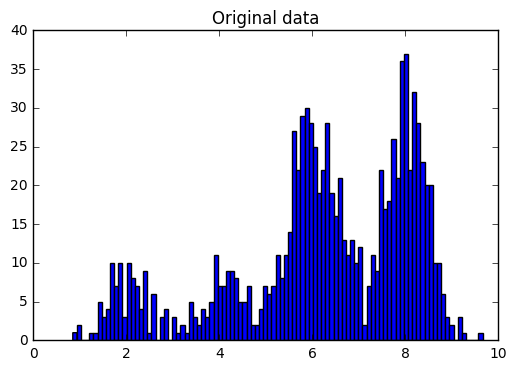

In [9]:
fig, ax = plt.subplots()
ax.hist(x, bins = bins)
ax.set_title("Original data")
None

In [10]:
if use_sorted:
    print("Using sorted data")
    indices = np.argsort(x, axis=0).flatten()
    x = x[indices]
    y = y[indices]
else:
    print("Using shuffled data")

sim = np.exp(-euclidean_distances(x, squared=True) / (2. * sigma_similarity ** 2))

Using sorted data


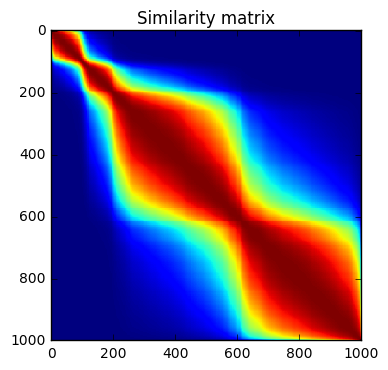

In [11]:
fig, ax = plt.subplots()
ax.imshow(sim, interpolation='none')
ax.set_title("Similarity matrix")

None

In [12]:
def nearest_neighbors(similarities, k):
    result = np.zeros_like(similarities)
    for i in range(similarities.shape[0]):
        indices = np.argpartition(similarities[i, :], kth=-k)[-k:]
        for j in indices:
            result[i, j] = similarities[i, j]
            result[j, i] = similarities[j, i]
    return result

In [13]:
def get_unnormalized_laplacian(adjacency):
    degrees = np.diag(np.sum(adjacency, axis=1))
    return degrees - adjacency

In [14]:
def get_normalized_laplacian(adjacency):
    '''Calculates L_rw = I - D^{-1} W, as defined in the tutorial'''
    adjacency = 0.5 * (adjacency.T + adjacency)
    degrees_inv = np.diag(1. / np.sum(adjacency, axis=1))
    L = np.identity(adjacency.shape[0]) - np.dot(degrees_inv, adjacency)
    return L

Using nearest-neighbors similarity


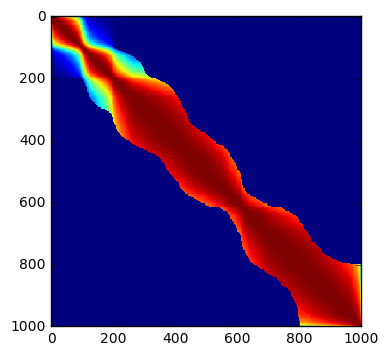

In [15]:
if use_nearest_neighbors:
    print("Using nearest-neighbors similarity")
    sim = nearest_neighbors(sim, num_neighbors)
    fig, ax = plt.subplots()
    ax.imshow(sim, interpolation='none')
else:
    print("Using dense similarity")

In [16]:
if use_normalized:
    print("Using normalized Laplacian L_rw")
    L = get_normalized_laplacian(sim)
else:
    print("Using unnormalized Laplacian")
    L = get_unnormalized_laplacian(sim)

Using unnormalized Laplacian


In [17]:
eigvals, eigvecs = np.linalg.eigh(L)

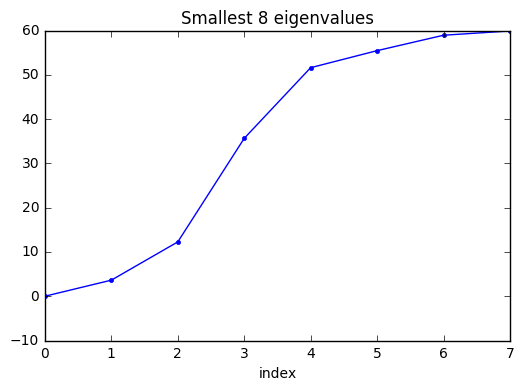

In [18]:
eigvals_to_plot = len(cluster_sizes)*2

fig, ax = plt.subplots()
ax.plot(eigvals[:eigvals_to_plot], '.-')
ax.set_title("Smallest {} eigenvalues".format(eigvals_to_plot))
ax.set_xlabel("index")
None

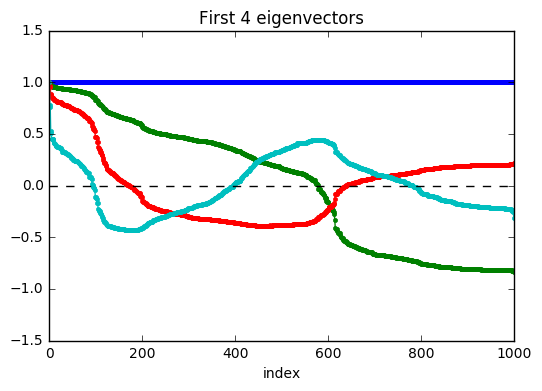

In [19]:
evecs = []
for i in range(len(cluster_sizes)):
    v = eigvecs[:, i]
    v /= np.max(np.abs(v))
    if -min(v) > max(v):
        v = -v
    evecs.append(v)

fig, ax = plt.subplots()
for v in evecs:
    ax.plot(v, '.-')
ax.axhline(y=0, color='black', linestyle='dashed')
ax.set_ylim(-1.5, 1.5)
ax.set_title("First {} eigenvectors".format(len(cluster_sizes)))
ax.set_xlabel("index")
None

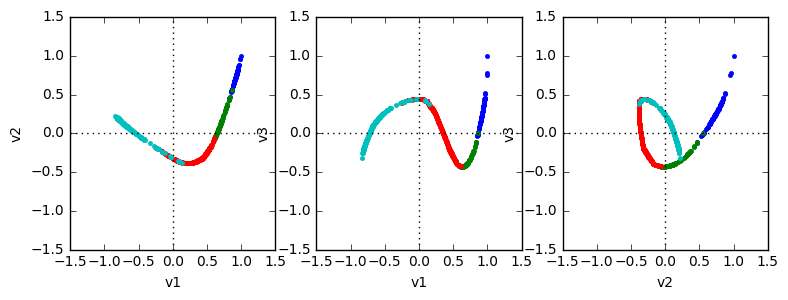

In [20]:
pairs = [(1,2), (1,3), (2,3)]
fig, ax = plt.subplots(1, len(pairs), squeeze=False)
fig.subplots_adjust(hspace=1)
fig.set_size_inches(len(pairs)*3, 3, forward=True)
for i, (j1, j2) in enumerate(pairs):
    c_ax = ax.flatten()[i]
    for label in range(len(cluster_sizes)):
        indices = y.flatten() == label
        c_ax.plot(evecs[j1][indices], evecs[j2][indices], '.')
    c_ax.axhline(y=0, color='k', linestyle=':')
    c_ax.axvline(x=0, color='k', linestyle=':')
    c_ax.set_xlim(-1.5, 1.5)
    c_ax.set_ylim(-1.5, 1.5)
    c_ax.set_xlabel("v{}".format(j1))
    c_ax.set_ylabel("v{}".format(j2))
None

In [21]:
cluster_labels = (evecs[1] > 0).astype('int')

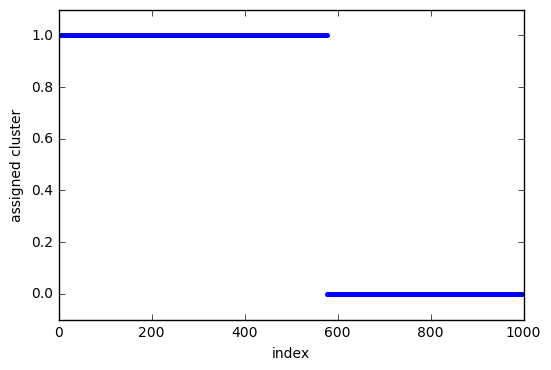

In [22]:
fig, ax = plt.subplots()
ax.plot(cluster_labels, '.')
ax.margins(y=0.1)
ax.set_xlabel("index")
ax.set_ylabel("assigned cluster")
None

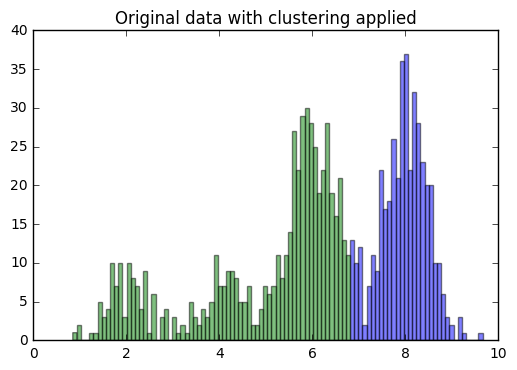

In [23]:
fig, ax = plt.subplots()
ax.hist(x[cluster_labels == 0], color='blue', alpha=0.5, bins=bins)
ax.hist(x[cluster_labels == 1], color='green', alpha=0.5, bins=bins)
ax.set_title("Original data with clustering applied")
None

### Let's try the inverse power iteration method

In [24]:
def conj_grad_alt(A, b, extra = None, num_iters = 10):
    '''
    Solve (A + sum[(w, v) in extra](w * v * v.T)) x = b using conjugate gradient.
    Ideally, A should be a sparse matrix stored in a Compressed Sparse Row (CSR) format.
    '''
    if extra is None:
        extra = []
        
    def mult(x):
        result = A.dot(x)
        for w, v in extra:
            result += w * v.T.dot(x) * v
        return result
        
    b = b.reshape((-1, 1))
    x = np.zeros_like(b)
    r = b - mult(x)
    p = r
    for k in range(num_iters):
        prev_r = r
        alpha = r.T.dot(r) / float(p.T.dot(mult(p)))
        x = x + alpha * p
        r = r - alpha * mult(p)
        beta = r.T.dot(r) / prev_r.T.dot(prev_r)
        p = r + beta * p
    return x

In [25]:
L_sparse = csr_matrix(L)
print("Maximum number of entries: {}".format(np.product(L_sparse.shape)))
print("Nonzero entries:           {}".format(L_sparse.nnz))

row_sizes = np.diff(L_sparse.indptr)
print("Range of row sizes:        {} - {}".format(np.min(row_sizes), np.max(row_sizes)))

Maximum number of entries: 1000000
Nonzero entries:           240656
Range of row sizes:        200 - 344


In [26]:
# Regular power iteration to get largest eigenvalue
v = np.random.uniform(-1, 1, (n_obs,))
num_iters = 10
for i in range(num_iters):
    v = L_sparse.dot(v)
    v /= np.linalg.norm(v)
    if -min(v) > max(v):
        v *= -1
lambda_N = v.dot(L_sparse.dot(v))
print("Largest eigenvalue: {}".format(lambda_N))

Largest eigenvalue: 293.803451612


In [27]:
# Since we know the smallest eigenvalue is 0, with an all-ones eigenvector,
# let's modify the spectrum so that this eigenvector no longer has the smallest eigenvalue

# Note: If we explicitly construct this matrix, it loses its sparsity.
# We should try to perform operations involving this matrix without explicitly constructing it.
# Lprime = L_sparse + (lambda_N + 1)*np.ones(n_obs)

v = np.random.uniform(-1, 1, (n_obs,))
v /= np.linalg.norm(v)

v_history = [v]

for i in range(num_iters):
    #v, _, _, _ = np.linalg.lstsq(Lprime, v)
    #v = np.linalg.solve(Lprime, v)
    v = conj_grad_alt(L_sparse, v, extra=[(lambda_N + 1, np.ones((n_obs, 1)))])
    v /= np.linalg.norm(v)
    if -min(v) > max(v):
        v *= -1
    v_history.append(v)

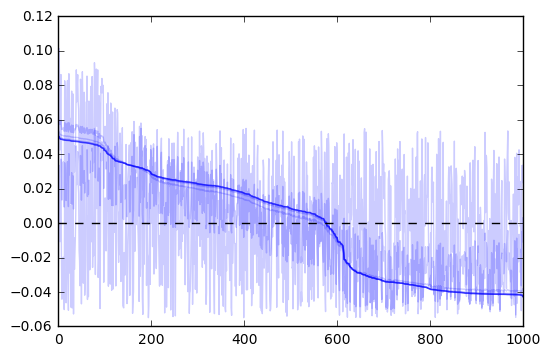

In [28]:
fig, ax = plt.subplots()
for i, vh in enumerate(v_history):
    ax.plot(vh, alpha=0.2, color='blue')
ax.axhline(y = 0, color='black', linestyle='dashed')
None

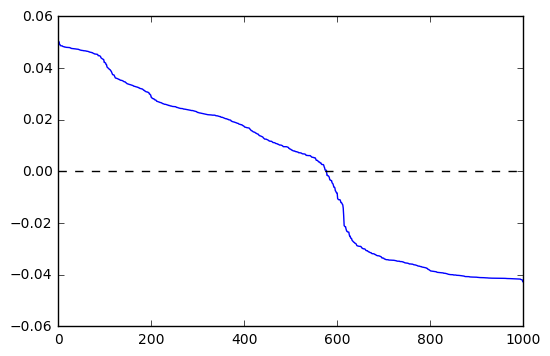

In [29]:
fig, ax = plt.subplots()
ax.plot(v)
ax.axhline(y=0, color='black', linestyle='dashed')
None

In [30]:
cluster_labels = (v > 0).astype('int')

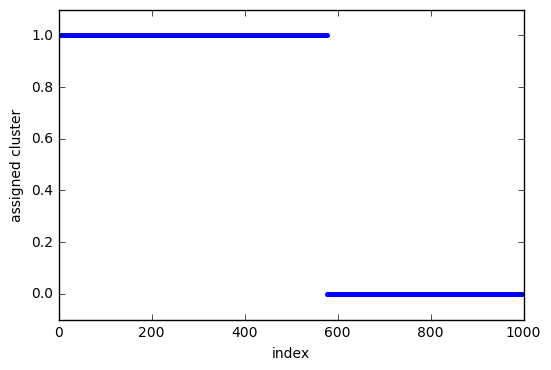

In [31]:
fig, ax = plt.subplots()
ax.plot(cluster_labels, '.')
ax.margins(y=0.1)
ax.set_xlabel("index")
ax.set_ylabel("assigned cluster")
None

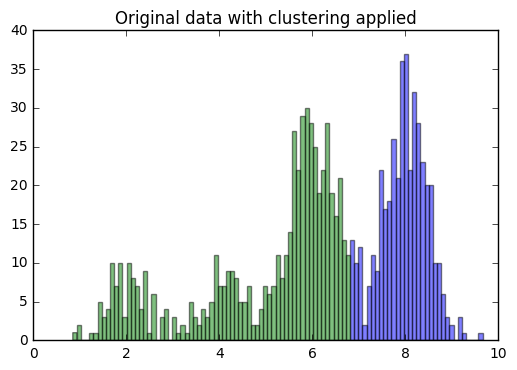

In [32]:
fig, ax = plt.subplots()
ax.hist(x[cluster_labels == 0], color='blue', alpha=0.5, bins=bins)
ax.hist(x[cluster_labels == 1], color='green', alpha=0.5, bins=bins)
ax.set_title("Original data with clustering applied")
None

In [ ]:
# partition:
#     build sparse knn graph (naive: O(kn^2))
#     calculate sparse similarity -- O(kn)
#     calculate laplacian L -- O(k n)
#     calculate largest eigenvalue via power iteration O(kn * num_iter_PI):
#         generate random start vector -- O(n)
#         repeatedly multiply by laplacian -- O(kn) per iteration
#     calculate smallest nonzero eigenvalue/eigenvector inverse power iteration
#         generate random start vector O(n)
#         repeatedly solve linear system:  x <- solve[(L + lambda_N * 1 * 1^T)y = x, y]
#         uses modification of conjugate gradient that handles
#             sparse matrix + outer product matrix
#         each conj_grad iteration uses O(nk * num_iter_CG)
#         altogether, this phase uses O(nk * num_iter_CG * num_iter_IPI)

# assuming num_iter_* params only depend on desired accuracy, not on data size (??)
# this overall runs in:
#     with naive knn graph: O(kn^2)
#     with better knn graph construction, we might get O(kn*log(n)) or even O(kn)

# TODO: investigate runtime of knn graph construction algorithms